In [20]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

# 1. Data preprocessing

### 1.1 Data filtering and features engineering

In this section, we conducted preliminary data cleaning, munging and engineering. The dataset is from yelp.com, including 4 datasets - user, check-in, review and business datasets. We first explored 4 datasets and tried to merge the dataset after data cleaning and features selecting.

In [3]:
# import yelp_business.csv
df_yelp_business = pd.read_json('s3://bucket_name/business.json')

# drop businesses that do not have any categories
df_yelp_business.dropna(subset=['categories'], inplace=True)

In [4]:
# Notice that the category feature is a set of words describing the restaurant, first we need to assign the
# restaurants to different concrete categories for further analysis

# select businesses that has 'restaurant' in categories
restaurant_business = df_yelp_business.loc[df_yelp_business.categories.str.contains('restaurant', regex=False, case=False)|(df_yelp_business.categories.str.contains('food', regex=False, case=False))]

In [5]:
restaurant_business.shape

(9709, 15)

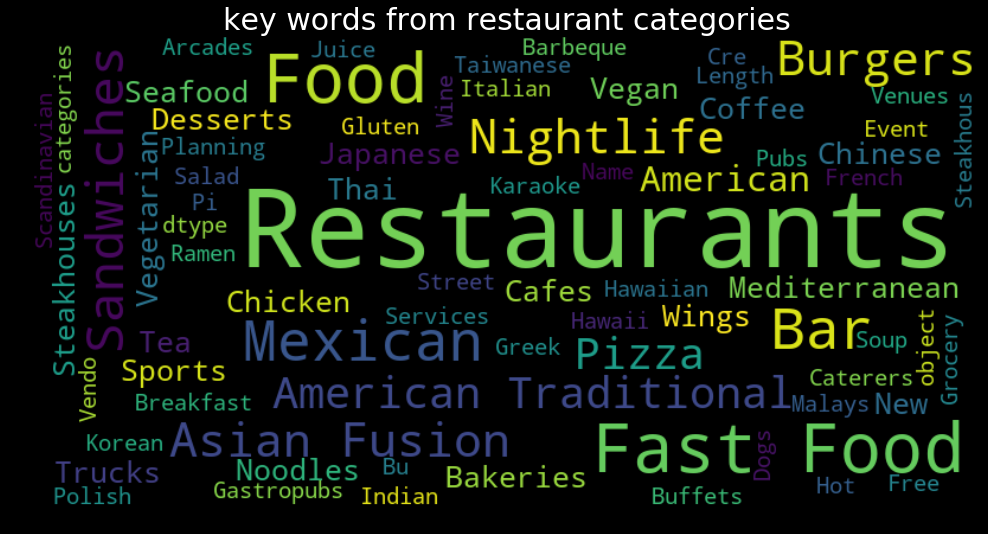

In [10]:
# create word cloud from categories
wc = WordCloud(width=800, height=400, random_state=1, max_words=200000000)
wc.generate(str(restaurant_business['categories']))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.title("key words from restaurant categories", fontsize=30,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of congiguration finally plot the graph
plt.show()

From the graph we can see that one possible way to classify restaurants is by cuisine. So we filter restaurants that have top 16 highest frequency cuisine.

In [50]:
import re

cuisines = ['american', 'burger','sandwich','mexican', 'chinese','italian', 'japanese', 'thai', 'mediterranean', 'hawaiian', 'korean', 'vietnamese', 'greek', 'filipino', 'french', 'greek', 'indian']
food_business_cuisine = restaurant_business.loc[restaurant_business.categories.str.contains('|'.join(cuisines), flags=re.IGNORECASE, regex=True)]

In [51]:
food_business_cuisine.shape

(5605, 15)

In [52]:
# filter restaurants in las vegas
las_vegas_restaurants = food_business_cuisine[food_business_cuisine.city.apply(lambda x: str(x).lower()).str.contains('las.*vegas')]

In [ ]:
# choose only the region with over 100 restaurants by zipcode
a = las_vegas_restaurants.groupby('postal_code').size().sort_values()
las_vegas_restaurants_over_100 = las_vegas_restaurants[las_vegas_restaurants.postal_code.isin(a[a>=100].index)]
las_vegas_restaurants_over_100.shape

In [60]:
# get the cuisine category for each business, if one business has several cuisine categories, then it will have multiple rows
new = las_vegas_restaurants_over_100.iloc[0:1,:]
for i in las_vegas_restaurants_over_100.business_id.values[1:]:
    label = str(las_vegas_restaurants_over_100[las_vegas_restaurants_over_100.business_id ==i].categories.values).lower()
    for ca in  ['american','mexican', 'chinese','italian', 'japanese', 'thai', 'mediterranean', 'hawaiian', 'korean', 'vietnamese', 'greek', 'filipino', 'french', 'greek', 'indian']:
        if ca == 'american':
            if 'burger' in label or 'sandwich' in label or 'american' in label:
                flag = True
        if ca in label:
            flag = True
        if flag:
            las_vegas_restaurants_over_100.loc[las_vegas_restaurants_over_100.business_id ==i,'categories'] = ca
            new = pd.concat([new, las_vegas_restaurants_over_100[las_vegas_restaurants_over_100.business_id ==i]],axis = 0)
            flag = False

new.iloc[0,3] = 'italian'

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [72]:
# drop variables we do not need
new.drop(['address','city','latitude', 'longitude', 'neighborhood', 'state'], inplace=True, axis=1)

In [75]:
# save dataframe to csv to S3
new.to_csv('final_las_vegas_business.csv',index=False)

import boto3, os
s3 = boto3.resource('s3')
s3.meta.client.upload_file('final_las_vegas_business.csv','bucket_name','final_las_vegas_business.csv')

### 1.2 Check-in times and special attributes exploring

In [4]:
# import needed data
df1 = pd.read_json('yelp_academic_dataset_checkin.json', lines = True)
df2 = pd.read_json('yelp_academic_dataset_business.json', lines = True)
biz_id = pd.read_csv('business_id.csv') # filtered id, which is generated by last step

In [8]:
### checkin
# deal with nested json format
time = (json_normalize(df1["time"], errors="ignore",meta=['business_id']))

df1_new = pd.concat([df1[['business_id']], time], axis=1)

# create new columns calculating the number of checkins based on week of day
checkin_fn = pd.merge(biz_id, df1_new, on='business_id', how='left')
checkin_fn = checkin_fn.loc[:,['business_id'] + [i+'-'+str(a) 
                             for i in ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
                             for a in range(24)]]
checkin_fn['Mon'] = checkin_fn.loc[:,['Mon-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Tue'] = checkin_fn.loc[:,['Tue-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Wed'] = checkin_fn.loc[:,['Wed-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Thu'] = checkin_fn.loc[:,['Thu-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Fri'] = checkin_fn.loc[:,['Fri-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Sat'] = checkin_fn.loc[:,['Sat-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Sun'] = checkin_fn.loc[:,['Sun-'+str(i) for i in range(24)]].sum(axis=1)
checkin_fn['Total'] = checkin_fn.iloc[:,1:169].sum(axis=1)

In [9]:
### restaurant attributes analysis
las_biz = pd.read_csv('las_vegas_business.csv', usecols=[i for i in range(1,23)])
df2_new = df2.drop(['address','latitude', 'longitude','neighborhood','categories',
                    'hours','is_open','name','postal_code','review_count','stars',
                    'city','state'], axis=1)
biz_fn = pd.merge(las_biz, df2_new, on='business_id', how='left')

In [10]:
# deal with nested json format
data = biz_fn[biz_fn["attributes"].apply(lambda x: str(x)) != 'None']
attr = (json_normalize(data.attributes, errors="ignore",meta=['business_id']))

# In order to ensure the accuracy of data, 
# we only select fectures with less than 7%
attr_prop = attr.isna().sum(axis = 0).sort_values()/len(attr)
names = attr_prop[attr_prop<.071].index.tolist()

attr_fn = attr.loc[:,names]

biz_attr_fn = pd.concat([data[['business_id']].reset_index(drop=True), 
                         attr_fn.reset_index(drop=True)], axis=1)
biz_attr_fn = biz_attr_fn.dropna()

In [11]:
# merge the check-in data and attributes data on business id
biz_checkin = pd.merge(las_biz, checkin_fn, on='business_id', how='left')

# export the data to s3
biz_checkin.to_csv('business_checkin.csv', index=False)
s3.meta.client.upload_file('business_checkin.csv','bucket_name','business_checkin.csv')

### 1.3 Review data filtering

Since the review dataset is larger than 4GB, which cannot be read from pandas, in order to simulate the situation where companies face a large dataset, we used SparkSQL in AWS Zeppelin to filter the review data to city that we focus on. After that, the dataset was saved in s3. The code is as following:

In [ ]:
%spark.pyspark
# Since the data of review is too large for pandas to read, we read the data in pyspark and do the filtering
review = sqlContext.read.json('s3://bucket_name/yelp_academic_dataset_review.json')
business = sqlContext.read.option('header','true').format('csv').load('s3://muyu/business_id.csv')

# create temporary table
review.registerTempTable('review')
business.registerTempTable('business_id')

# filter the review data
filtered_review = sqlContext.sql('select * from review as r where r.business_id in (select b.business_id from business_id b)')
filtered_review.registerTempTable('filtered_review')

# export the filtered_review for further sentiment analysis
filtered.coalesce(1).write.json('s3://muyu/review')

### 1.4 Data merging

In [ ]:
# read data
category = pd.read_csv('s3://bucket_name/final_las_vegas_business.csv')
checkin = pd.read_csv('s3://bucket_name/business_checkin.csv')
attributes = pd.read_csv('s3://bucket_name/business_with_attributes.csv')
reviews = pd.read_json('s3://bucket_name/review/reviews.json',lines=True)

# merge data
data = pd.merge(category.drop(['attributes','hours'],axis = 1),attributes,on='business_id')
data = pd.merge(data,checkin.loc[:,['business_id','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Total']])

# export data without review to business_data.csv
data.to_csv('business_data.csv',index=False)
# upload data to S3 folder
s3.meta.client.upload_file('business_data.csv', 'bucket_name', 'business_data.csv')

# merge review data
data = pd.merge(data, reviews.loc[:,['business_id','cool','date','funny','useful','text']],on='business_id')
data = data.rename(columns={'stars_x':'overall_rating','stars_y':'review_ratinga'})

# export data with review to data_with_review.csv
data.to_csv('data_with_review.csv', index=False)
s3.meta.client.upload_file('data_with_review.csv', 'bucket_name', 'data_with_review.csv')

# 2. Exploratory Analysis

### 2.1 Features correlation analysis

In this section, we use linear regression model to identify the most correlated features with rating and review counts, which by hypothesis is regarded to be a reflection on demand.

In [15]:
import numpy as np
import statsmodels.formula.api as smf
data = pd.read_csv('s3://bucket_name/business_data.csv')
# Feature Correlation Analysis
# After serveral rounds of feature selection, we finalize with four features which are most correlated to ratings.
mod_rating = smf.ols(formula = 'stars ~ C(RestaurantsGoodForGroups) + \
                                        C(RestaurantsReservations) + \
                                        C(OutdoorSeating) + C(RestaurantsDelivery)', data = data)
res_rating = mod_rating.fit()
print(res_rating.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     66.80
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           1.76e-54
Time:                        02:01:43   Log-Likelihood:                -3634.7
No. Observations:                3396   AIC:                             7279.
Df Residuals:                    3391   BIC:                             7310.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

Conclusion:
* Whether the restaurant is good for groups, which indicates the area of the place, could not be too small.
* Whether the restaurant offers reservation, outdoor seating, delivery services is higly correlated to the ratings.

In [16]:
mod_review_count = smf.ols(formula = 'review_count ~ C(RestaurantsTakeOut) + C(RestaurantsReservations) + \
                                    C(OutdoorSeating) + C(RestaurantsDelivery)', data = data)
res_review_count = mod_review_count.fit()
print(res_review_count.summary())

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     52.40
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           6.83e-43
Time:                        02:02:51   Log-Likelihood:                -25504.
No. Observations:                3396   AIC:                         5.102e+04
Df Residuals:                    3391   BIC:                         5.105e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Conclusion:
* Whether the restaurants offers takeout and delivery serives would be negatively correlated to the review counts, probably because people don't receive services in person so that they are not motivated to submit a review. A strategy to increase the reviews could be launching motivation strategies for takeout and delivery service, for example, reducing the delivery fee or offering discount as an incentive.
* Reservation and outdoor seating services are preferable for customers.

### 2.2 Region and Category Exploration Analysis

In this section, we used SparkSQL in Zeppelin to conduct the analysis, because Zeppelin provides a good environment for analysis by integrating visualization to SQL query. Therefore, we analyzed the restaurants in Las Vegas mainly focusing on two indicators - rating and review counts. The codes are as following:

In [ ]:
# Spark Codes here
%pyspark
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

%pyspark
data =  's3://bucket_name/business_data.csv'


%pyspark
vegas = sqlContext.read.option('inferSchema', 'True').option('Header', 'True').format('csv').load(data)


%pyspark
# Temp Tables
vegas.registerTempTable('vegas')



%sql
select city, count(city) as Count_of_Resturants from yelp group by city order by count(city) DESC limit 10


%sql
select categories, avg(stars) as Avg_Stars, count(stars) as Count from vegas group by categories order by count(stars) DESC


%sql

select categories, avg(stars) as Avg_Stars, count(stars) as Count from vegas group by categories order by count(stars) DESC Limit 8


%sql
select postal_code, avg(stars) as Avg_Stars from vegas where categories = 'chinese' group by postal_code order by count(stars)



%sql
select postal_code, avg(stars) as Avg_Stars from vegas where categories = ${'american'} group by postal_code order by count(stars)


%sql
select name, count(text) as Count, avg(R.stars) Avg_Stars from vegas join review as R using (business_id) where (postal_code = '89119' or postal_code = '89109') and categories = 'chinese' group by name


%sql
select sum(Mon) as Monday, sum(Tue) as Tuesday, sum(Wed) as Wednesday, sum(Thu) as Thursday, sum(Fri) as Friday, sum(Sat) as Saturday, sum(Sun) as Sunday from vegas 
where postal_code = ${Zipcode = 89119} and categories = 'chinese'

Conclusion:
* Las vegas has most restaurants in American, Chinese and Mexican categories
* Chinese restaurants have the least rating among all categories
* Within Chinese restaurants zip codes 89119 and 89109 have the least rating value
* For the chinese restaurants in these zip codes Saturday through Monday have the maximum checkins

### 2.3 Sentiment Analysis

In this section, we conducted sentiment analysis on the specific category and region that we would recommend to target in, in order to find out the detailed demand and preference of customers.

In [7]:
reviews = pd.read_csv('s3://bucket_name/data_with_review.csv')

In [8]:
reviews.categories = reviews.categories.astype('str')

# filter reviews from chinese restaurants
chinese = reviews.loc[reviews.categories == 'chinese']

In [9]:
# clean stop words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
new_stop = ['ever', 'had']
stop = set(list(stop) + new_stop)
not_stopwords = {'not', 'no', "wasn't", "wasn', 'aren'"}
final_stop_words = set([word for word in stop if word not in not_stopwords])

chinese['clean_text'] = chinese['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in final_stop_words]))

/Users/laurence/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


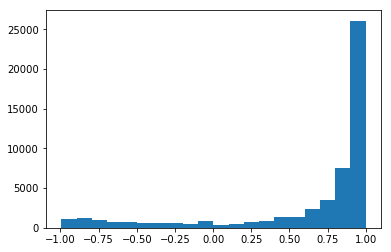

In [21]:
# calculate compound score from Vader 

from nltk.sentiment.vader import SentimentIntensityAnalyzer

chinese_reviews = list(chinese['clean_text'])

analyzer = SentimentIntensityAnalyzer()

scores = [analyzer.polarity_scores(review)['compound'] for review in chinese_reviews]
plt.hist(scores, bins=20)
plt.show()

In [22]:
chinese['text_score'] = scores

/Users/laurence/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


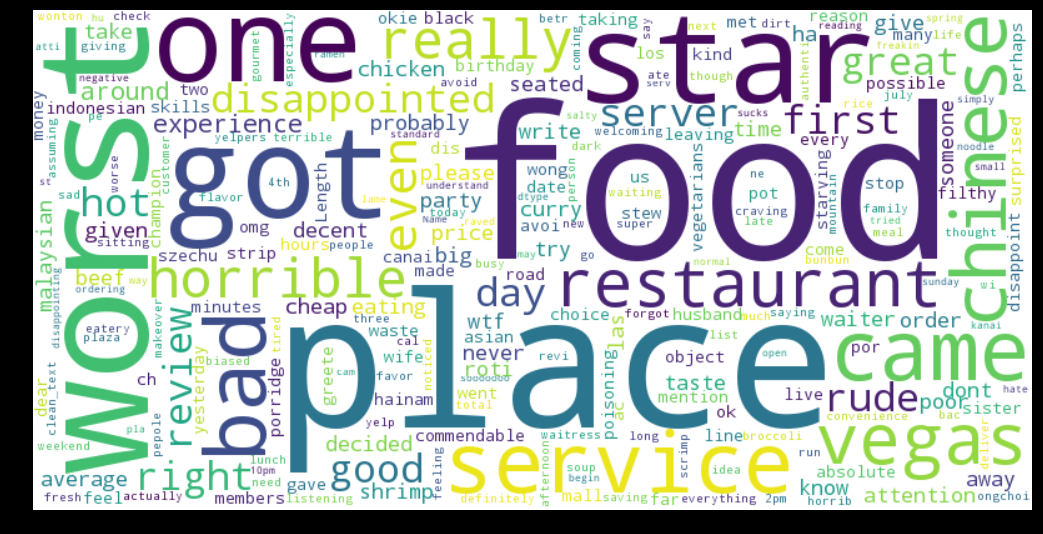

In [23]:
# word cloud from reviews that has socre below -0.5 (negative reviews)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(width=800, height=400, random_state=1, max_words=200000000, background_color='white')
wc.generate(str(chinese['clean_text'].loc[chinese.text_score < -0.50]))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of congiguration finally plot the graph
plt.show()

In [24]:
## finding bi-gram and trigram frequencies
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(chinese['clean_text'].loc[chinese.text_score < -0.5])
frequencies = sum(sparse_matrix).toarray()[0]
k = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
                                                                                  
chinese_review_word = k.reset_index().sort_values('frequency', ascending = False)
chinese_review_word['gram_type'] = chinese_review_word['index'].str.count(' ') + 1

chinese_review_word_1gram = chinese_review_word[chinese_review_word['gram_type']==1]
chinese_review_word_2gram = chinese_review_word[chinese_review_word['gram_type']==2]
chinese_review_word_3gram = chinese_review_word[chinese_review_word['gram_type']==3]

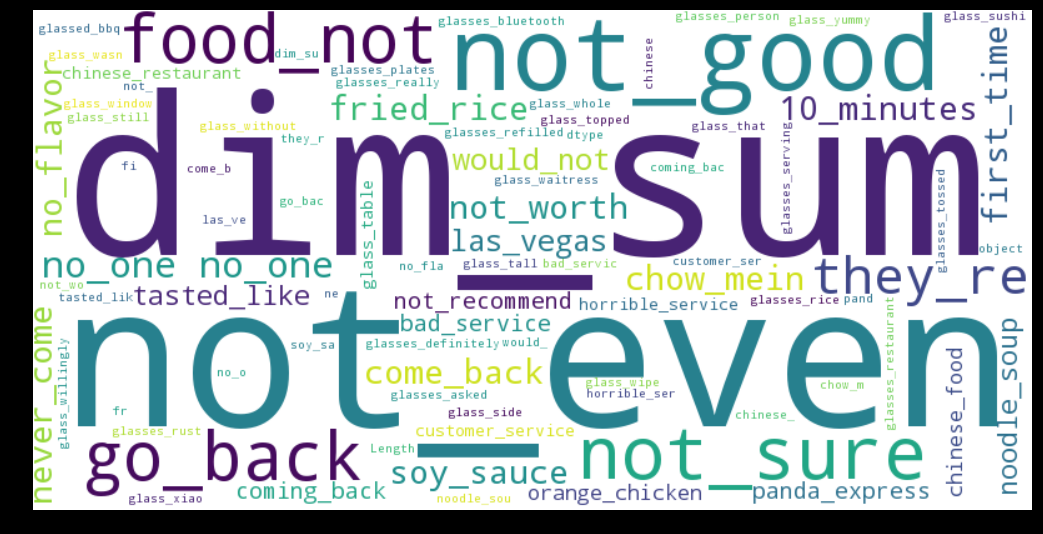

In [25]:
# bi-gram word cloud
a=chinese_review_word_2gram.iloc[:,[0,1]].apply(lambda x: (x[0].replace(' ','_') + ' ') * int(x[1]),axis=1)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(width=800, height=400, random_state=1, max_words=200000000, background_color='white')
wc.generate(str(a))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of congiguration finally plot the graph
plt.show()

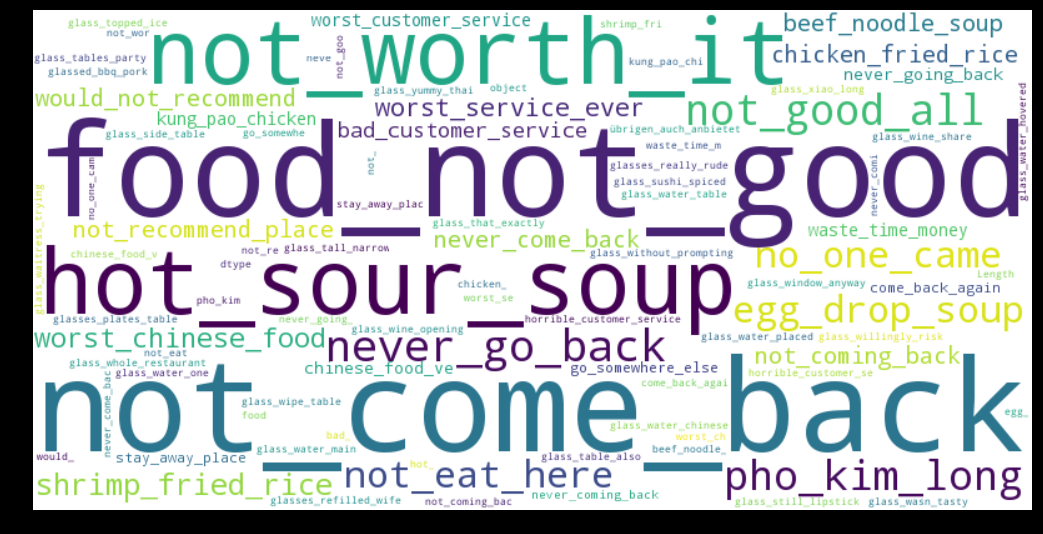

In [26]:
# tri-gram word cloud
a=chinese_review_word_3gram.iloc[:,[0,1]].apply(lambda x: (x[0].replace(' ','_') + ' ') * int(x[1]),axis=1)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(width=800, height=400, random_state=1, max_words=200000000, background_color='white')
wc.generate(str(a))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of congiguration finally plot the graph
plt.show()

To further explore the detail of the complaint, we use SparkSQL to find out what exactly customers were complaining about, the reason and their demand.

In [ ]:
%spark.pyspark
data_review = sqlContext.read.format('csv').option('header','true').load('s3://bucket_name/negative_chinese_reviews.csv')
data_review.registerTempTable('review')

%spark.sql
-- Discover what people complain about in detail and the reason, so that we better understand customers' need 
SELECT `text`, name, overall_rating, review_rating, `text`
  FROM review
 WHERE `text` like '%dim%sum%'
   AND categories = 'chinese'
   AND review_rating = 1

Conclusion:
* From the sentiment analysis, we noticed that service is the most important factor about customer satisfaction. It seems that Chinese restaurants didn't do well in service in this region. Therefore, it'd be one of the competitive advantages we can have if we focus on providing satifying services.
* We also noticed that some special food were complained mor frequently. For example, dim sum, noodle, fried rice and hot sour soup. When lauching similar products, we need to conduct more research on the preference of the custommers and even make localization.

### 2.4 Location visualization analysis

In the last section, we focused on the specific region and category, pinned all the existing Chinese restaurants in the map using packages in the Zeppelin platform in order to better understanding the market and the behavior of our competitors. 

In [ ]:
%spark.pyspark
from pyspark.sql import SQLContext

sqlCtx = SQLContext(sc)

business = sqlCtx.read.format("json") \
    .option("inferSchema", True) \
    .load('s3://bucket_name/yelp_academic_dataset_business.json')

business.registerTempTable("biz")

%spark.sql
# visualize the location of the chinese restaurant in one specific area
SELECT city, name, latitude, longitude
FROM biz
WHERE LOWER(city) LIKE '%las%vegas%'
AND LOWER(categories) LIKE '%chinese%'
AND postal_code = 89109